In [6]:
%%capture

import time
# Start the timer
start_time = time.time()

#Install Packages
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark==3.0.1
!pip install tensorflow==2.8.0 #2.5.0
!pip install --upgrade keras
!pip install elephas==0.4.3
!pip install chempy

#Import libraries for system operations and environment management
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

import sys
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

import warnings
# Suppress only specific warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress UserWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Suppress DeprecationWarnings

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

In [13]:
#Verify version for dependencies
import tensorflow as tf
import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Python version:")
print(sys.version)
print()

TensorFlow version: 2.8.0
Keras version: 2.8.0
Python version:
3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]



In [14]:
# Start the timer
start_time = time.time()

# Import the necessary third party packages
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('Elephas_App').setMaster('local[8]')
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.types import IntegerType, FloatType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, count, split, lit, udf
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import PCA, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import Window
from pyspark.sql.functions import expr

import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from chempy.kinetics.ode import get_odesys
from chempy.kinetics.rates import MassAction
from chempy import Equilibrium, Substance
from scipy.optimize import fsolve

# TensorFlow and Keras for deep learning (for future work)
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, serialize
from tensorflow.keras.utils import *
from tensorflow.python.keras.utils import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from elephas.utils.rdd_utils import to_simple_rdd
from elephas.spark_model import SparkModel
from elephas.ml_model import ElephasEstimator
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import serialize

# Set seaborn style for better visualizations
sns.set(style="whitegrid")

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

WARNING
Data transformation execution time: 4.57 seconds


In [15]:
# Start the timer
start_time = time.time()

conf = SparkConf().setAppName('Elephas_App').setMaster('local[8]') # keep due to dependencies
#sc = SparkContext(conf=conf)

#comment or uncomment the code block that suits your computing architecture

# Initialize Spark session (default)
#spark = SparkSession.builder \
 #   .appName("Beer Quality Analysis") \
 #   .config("spark.sql.shuffle.partitions", "50") \
 #   .config("spark.executor.memory", "4g") \
 #   .config("spark.executor.cores", "4") \
 #   .getOrCreate()

# Initialize Spark session (optimized CPU)
spark = SparkSession.builder \
    .appName("Beer Quality Analysis") \
    .config("spark.sql.shuffle.partitions", "50") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

# Initialize the Spark session (optimized T4_GPU)
#spark = SparkSession.builder \
 #   .appName("Beer Quality Analysis") \
 #   .config("spark.sql.shuffle.partitions", "100") \
 #   .config("spark.driver.memory", "16g") \
 #   .config("spark.executor.memory", "8g") \
 #   .config("spark.executor.cores", "4") \
 #   .config("spark.driver.maxResultSize", "8g") \
 #   .config("spark.executor.instances", "1") \
 #   .getOrCreate()

# Print Spark configuration settings
spark.sparkContext.setLogLevel("DEBUG")
#spark.sparkContext.setCheckpointDir("/tmp/spark-checkpoints")
print(spark.sparkContext.getConf().getAll())

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


[('spark.executor.memory', '4g'), ('spark.driver.host', '83c8fcd74309'), ('spark.driver.port', '43371'), ('spark.executor.id', 'driver'), ('spark.app.id', 'local-1722201028162'), ('spark.executor.cores', '2'), ('spark.app.name', 'Beer Quality Analysis'), ('spark.sql.shuffle.partitions', '50'), ('spark.rdd.compress', 'True'), ('spark.driver.memory', '8g'), ('spark.serializer.objectStreamReset', '100'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.submit.deployMode', 'client'), ('spark.ui.showConsoleProgress', 'true'), ('spark.driver.maxResultSize', '4g')]
Data transformation execution time: 10.57 seconds


Explanation of the Settings:
spark.sql.shuffle.partitions: Sets the number of partitions to use when shuffling data for joins or aggregations. A value of 50 is a good starting point.
spark.driver.memory: Allocates 8 GB of memory for the Spark driver. This is where the main control of your Spark application happens.
spark.executor.memory: Allocates 4 GB of memory for each Spark executor. Executors are the distributed agents that perform the tasks.
spark.executor.cores: Allocates 2 CPU cores for each executor. This helps in parallelizing the tasks effectively.
spark.driver.maxResultSize: Limits the maximum size of results that can be collected to the driver. Setting this to 4 GB prevents out-of-memory errors when collecting large results.

In [16]:
# Start the timer
start_time = time.time()

# Load data set
beer_sample_set = spark.read.csv('sample_data/beer_sample_set.csv', header=True, inferSchema=True)

# Preview the dataset shape and first few rows
print("Dataset shape: Rows -", beer_sample_set.count(), " Columns -", len(beer_sample_set.columns))
print("Schema of the dataset:")
beer_sample_set.printSchema()

print("First few rows of the dataset:")
beer_sample_set.show(5)  # Show the first 5 rows

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

Dataset shape: Rows - 250000  Columns - 20
Schema of the dataset:
root
 |-- Batch_ID: integer (nullable = true)
 |-- Brew_Date: string (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Fermentation_Time: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: integer (nullable = true)
 |-- Color: integer (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Volume_Produced: integer (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)

First few rows of the data

Categorical, numeric, and mixed numeric values to be processed accordingly.

In [17]:
# Start the timer
start_time = time.time()

# Create a copy of the DataFrame to not alter original
beer_copy = beer_sample_set

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


Data transformation execution time: 0.00 seconds


In [18]:
# Start the timer
start_time = time.time()

# Compute summary statistics
describe_df = beer_copy.describe()

# Show the summary statistics
describe_df.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

+-------+---------------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+--------------------+------------------+------------------+-----------------+----------------+------------------+------------------+------------------+--------------------+-------------------+------------------------+----------------------------+
|summary|       Batch_ID|          Brew_Date|Beer_Style|    SKU|       Location|Fermentation_Time|       Temperature|          pH_Level|             Gravity|   Alcohol_Content|        Bitterness|            Color|Ingredient_Ratio|   Volume_Produced|       Total_Sales|     Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|
+-------+---------------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+--------------------+------------------+------------------+-----------------+----------------+----

Focusing on the column subset related to the chemical properties of beer, the pH seems consistently below 7. Average temperatue slightly  below room standard room temperature. The bitterness has a large standard deviation relative to the mean.

The standard metric taht will be used for this analysis of quality score seems to have a small standard deviation and the scores all seem  to be high in a range of 6-9.99 with an average score of 7.99.

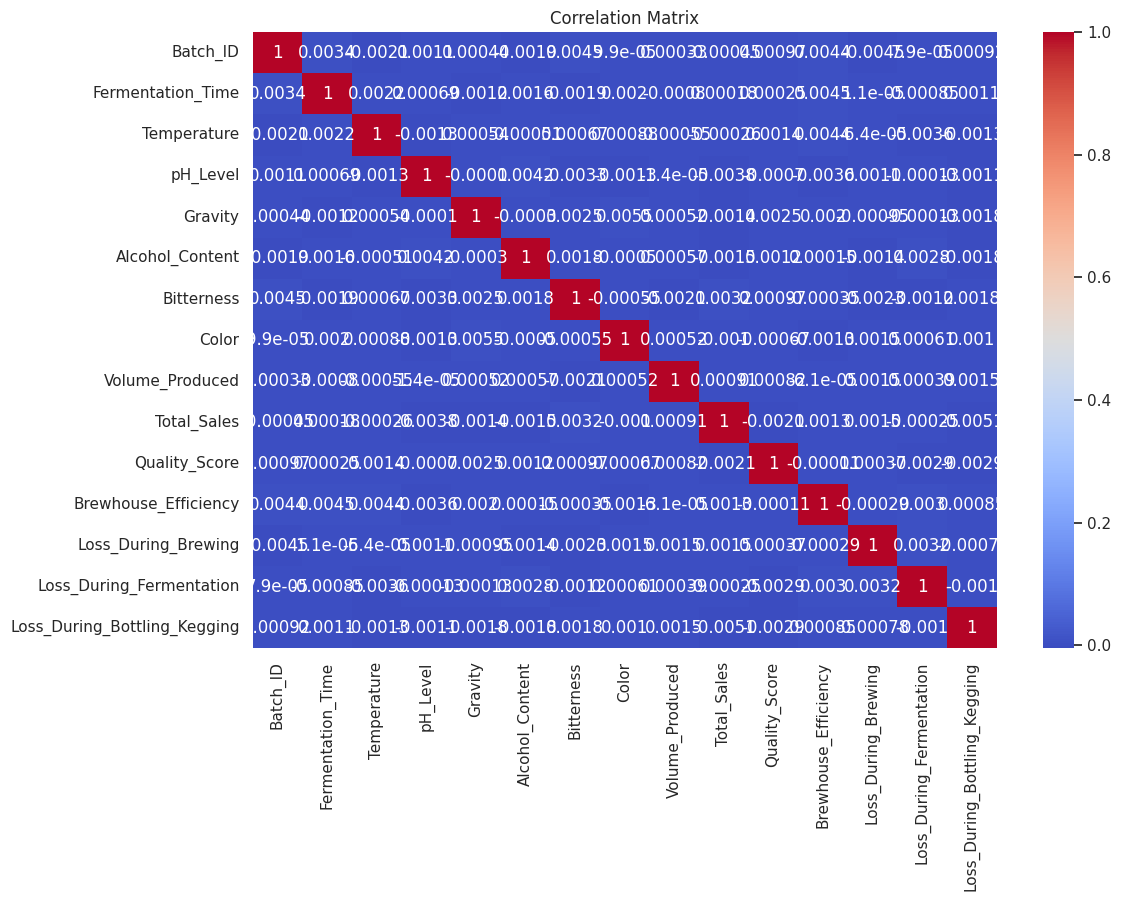

Data transformation execution time: 317.30 seconds


In [19]:
# Start the timer
start_time = time.time()

# Select numeric columns
numeric_columns = [field.name for field in beer_copy.schema.fields if isinstance(field.dataType, (IntegerType, FloatType, DoubleType))]

# Compute the correlation matrix
corr_matrix = pd.DataFrame(columns=numeric_columns, index=numeric_columns)

for col1 in numeric_columns:
    for col2 in numeric_columns:
        corr_value = beer_copy.stat.corr(col1, col2)
        corr_matrix.at[col1, col2] = corr_value

# Convert the correlation matrix to float
corr_matrix = corr_matrix.astype(float)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")



The most notable insight here is that the correlation plot seems to be completely uniform. Processing this data set will be challenging. To discover the relationships will require advanced techniques and deep domain knowledge.

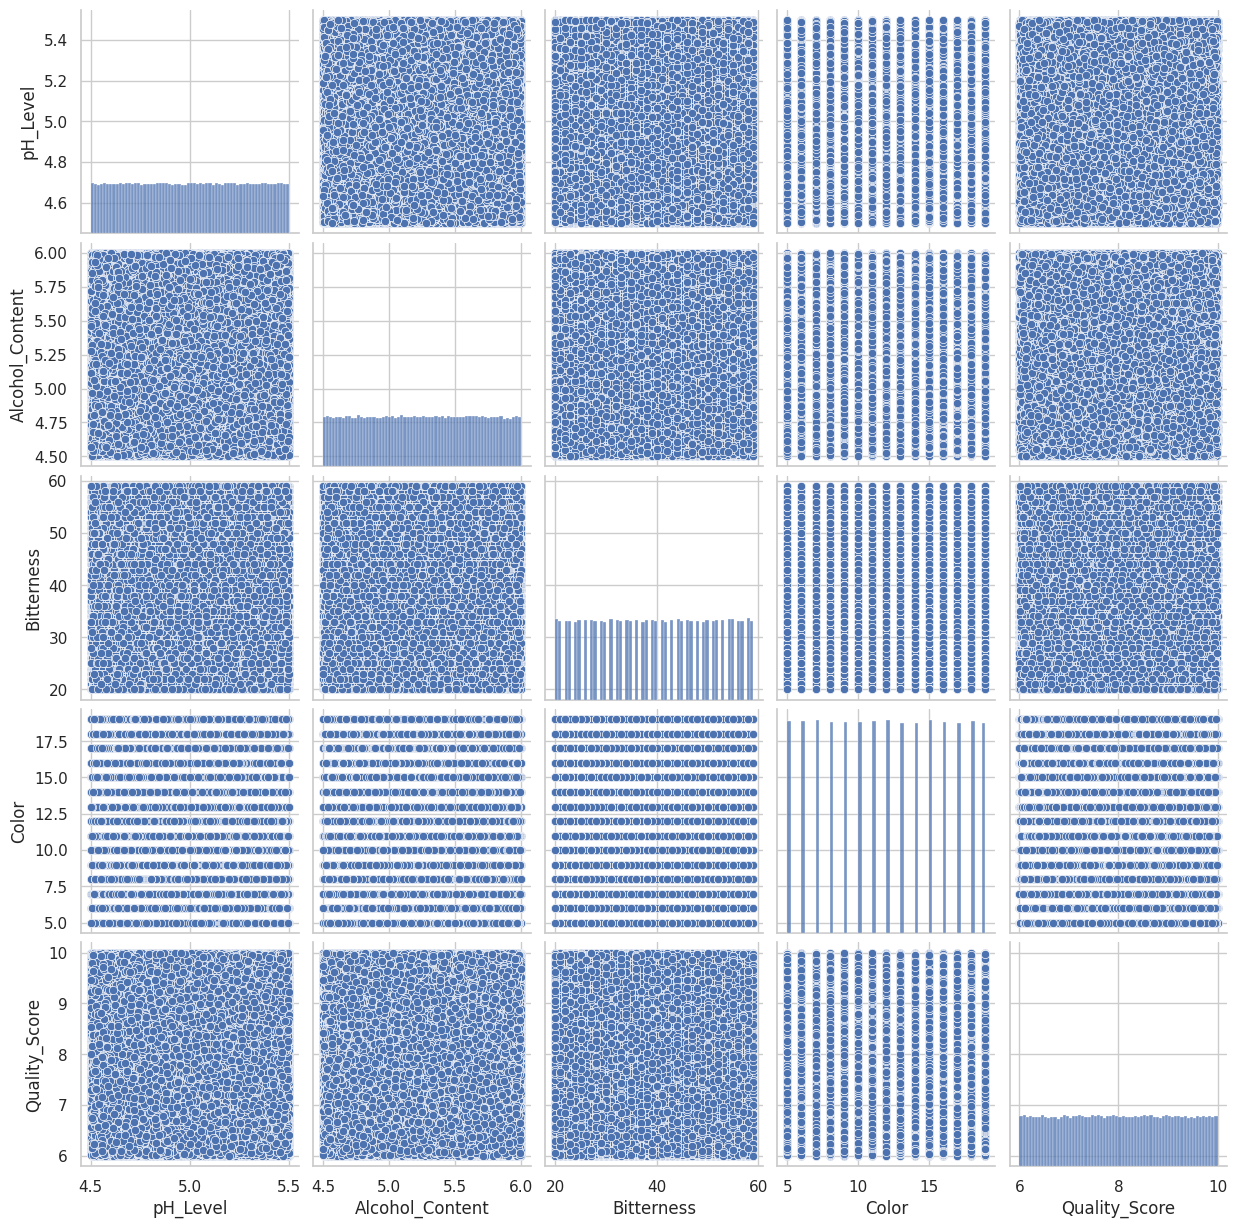

Data transformation execution time: 42.46 seconds


In [20]:
# Start the timer
start_time = time.time()

# Select relevant numerical columns
numeric_columns = ['pH_Level', 'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score']

# Collect the data as a Pandas DataFrame
beer_sample_pandas = beer_copy.select(numeric_columns).toPandas()

# Plot the pair plot
sns.pairplot(beer_sample_pandas)
plt.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


This confirms the correlation plot consculsion. These pair plots show flat and uniform data. This shows how important this step in the preprocessing is because without these plots, it wouldn't be so obvious that the data set would be a challenge for finding relationships.

In [21]:
# Start the timer
start_time = time.time()

# Define the columns relevant for feature engineering (features that contain chemistry dependent properties)
relevant_columns = ['pH_Level', 'Ingredient_Ratio', 'Fermentation_Time', 'Temperature',
                    'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score']
categorical_columns = ['Beer_Style']

# Create a subset of the data with relevant columns
beer_quality_predict = beer_copy.select(relevant_columns + categorical_columns)

# Preview the subset of the data
print("Subset of the data with relevant columns:")
beer_quality_predict.show(5)

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

Subset of the data with relevant columns:
+-----------------+----------------+-----------------+------------------+-----------------+----------+-----+------------------+----------+
|         pH_Level|Ingredient_Ratio|Fermentation_Time|       Temperature|  Alcohol_Content|Bitterness|Color|     Quality_Score|Beer_Style|
+-----------------+----------------+-----------------+------------------+-----------------+----------+-----+------------------+----------+
|4.944503974002884|     1:0.26:0.17|               15|15.070090125033419|5.104898993833054|        20|   19| 6.366748257130027|     Stout|
|5.403599353484238|     1:0.31:0.10|               19|15.563834668876087|5.075242393138411|        57|   14| 6.895412756770233|Wheat Beer|
|4.660538882478159|     1:0.32:0.21|               18|17.472288049501394|4.864122014861875|        20|    9| 6.964136947062722|      Sour|
|4.771273358916878|     1:0.32:0.24|               14|19.652671578475804|  5.8312391872117|        20|   19|6.68324419216492

This analysis will focus on the chemical properties of the beer making process that lead to top quality scores (cite reference for quality score as a metric - sales can also be used as a metric in a future analysis, consider brand building here). So here a chemical properties data subset is formed.

In [22]:
# Start the timer
start_time = time.time()

# Show schema of the DataFrame
beer_quality_predict.printSchema()

# Show summary statistics for numerical columns
beer_quality_predict.describe().show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


root
 |-- pH_Level: double (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Fermentation_Time: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: integer (nullable = true)
 |-- Color: integer (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Beer_Style: string (nullable = true)

+-------+------------------+----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+----------+
|summary|          pH_Level|Ingredient_Ratio|Fermentation_Time|       Temperature|   Alcohol_Content|        Bitterness|            Color|     Quality_Score|Beer_Style|
+-------+------------------+----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+----------+
|  count|            250000|          250000|           250000|            250000|         

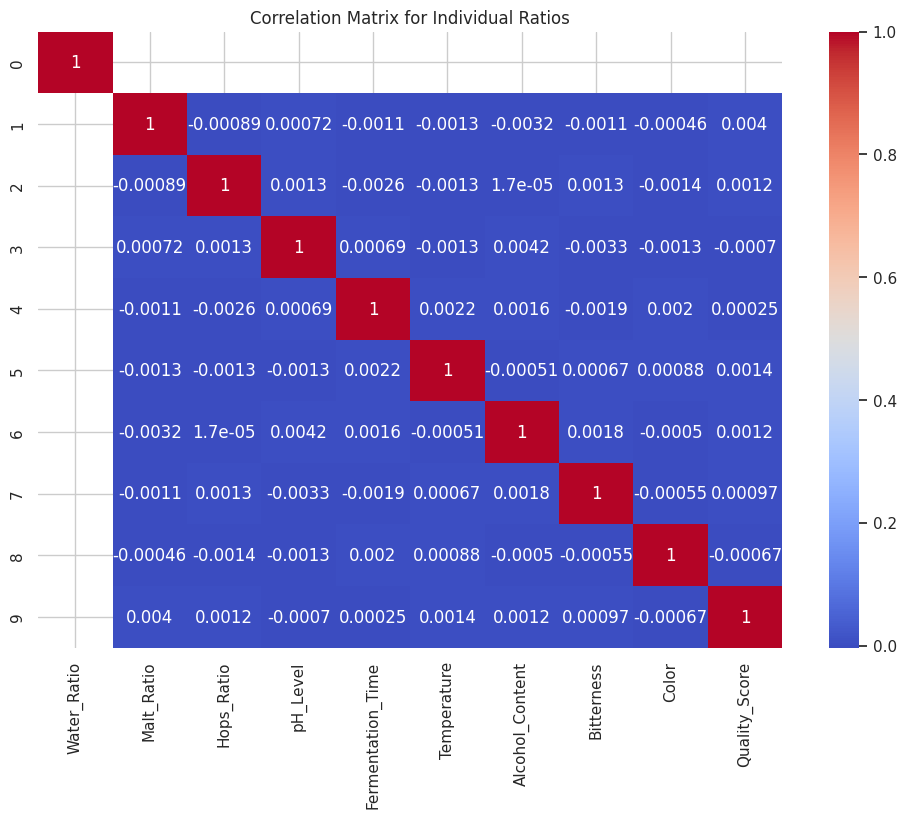

Data transformation execution time: 18.73 seconds


In [23]:
# Start the timer
start_time = time.time()

# Extract Individual Components
beer_quality_predict = beer_quality_predict.withColumn('Water_Ratio', lit(1.0))
beer_quality_predict = beer_quality_predict.withColumn('Malt_Ratio', split(col('Ingredient_Ratio'), ':').getItem(1).cast('float'))
beer_quality_predict = beer_quality_predict.withColumn('Hops_Ratio', split(col('Ingredient_Ratio'), ':').getItem(2).cast('float'))

# Assemble all relevant features into a vector
vector_col = 'features'
assembler = VectorAssembler(inputCols=['Water_Ratio', 'Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature',
                                       'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score'], outputCol=vector_col)
df_vector = assembler.transform(beer_quality_predict).select(vector_col)

# Calculate Correlation Matrix
matrix = Correlation.corr(df_vector, vector_col).head()[0]
corr_matrix_indv = pd.DataFrame(matrix.toArray(), columns=['Water_Ratio', 'Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature',
                                                           'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score'])

# Visualize Correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_indv, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Individual Ratios')
plt.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


remarkably uniform. Traditional coreelation matrices would show hints of a relationship. In this case, a deep dive into domain knowledge will be used to look closely for any relationships in the raw data.

In [24]:
# Start the timer
start_time = time.time()

# Create Combined Ratio Feature
beer_quality_predict = beer_quality_predict.withColumn('Malt_Hops_Ratio', col('Malt_Ratio') / col('Hops_Ratio'))

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

Data transformation execution time: 0.04 seconds


talk about the ingredient ratio - water: malt: hops and how chemistry tells us that. Separate out the water, malt and hops and also create a feature column of malt to hops.

In [25]:
# Start the timer
start_time = time.time()

# Function to infer malt type from color
beer_quality_predict = beer_quality_predict.withColumn(
    'Malt_Type',
    when(col('Color') < 10, 'Barley')
    .when((col('Color') >= 10) & (col('Color') < 20), 'Wheat')
    .when((col('Color') >= 20) & (col('Color') < 30), 'Rye')
    .otherwise('Oats')
)

# Function to infer hops type from bitterness
beer_quality_predict = beer_quality_predict.withColumn(
    'Hops_Type',
    when(col('Bitterness') > 40, 'Bittering')
    .when((col('Bitterness') > 20) & (col('Bitterness') <= 40), 'Dual Purpose')
    .otherwise('Aroma')
)

# Show the updated DataFrame with the new engineered features
beer_quality_predict.select('Color', 'Malt_Type', 'Bitterness', 'Hops_Type').show(5)

# One-hot encode categorical variables for machine learning models
categorical_columns = ['Beer_Style', 'Malt_Type', 'Hops_Type']

# Create a list to hold the stages of the Pipeline
stages = []

# Loop through each categorical column and create a StringIndexer and OneHotEncoder for each
for colm in categorical_columns:
    indexer = StringIndexer(inputCol=colm, outputCol=colm + '_Index')
    encoder = OneHotEncoder(inputCol=colm + '_Index', outputCol=colm + '_Vec')
    stages += [indexer, encoder]

# Apply the stages of the Pipeline to the DataFrame
pipeline = Pipeline(stages=stages)
beer_encoded = pipeline.fit(beer_quality_predict).transform(beer_quality_predict)

# Show the resulting DataFrame with the one-hot encoded columns
print("One-hot encoded dataframe:")
beer_encoded.select([colm for colm in beer_encoded.columns if 'Vec' in colm]).show()

# Preview the entire DataFrame
beer_encoded.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


+-----+---------+----------+------------+
|Color|Malt_Type|Bitterness|   Hops_Type|
+-----+---------+----------+------------+
|   19|    Wheat|        20|       Aroma|
|   14|    Wheat|        57|   Bittering|
|    9|   Barley|        20|       Aroma|
|   19|    Wheat|        20|       Aroma|
|   17|    Wheat|        37|Dual Purpose|
+-----+---------+----------+------------+
only showing top 5 rows

One-hot encoded dataframe:
+--------------+-------------+-------------+
|Beer_Style_Vec|Malt_Type_Vec|Hops_Type_Vec|
+--------------+-------------+-------------+
| (7,[2],[1.0])|(1,[0],[1.0])|    (2,[],[])|
| (7,[0],[1.0])|(1,[0],[1.0])|(2,[1],[1.0])|
| (7,[3],[1.0])|    (1,[],[])|    (2,[],[])|
| (7,[6],[1.0])|(1,[0],[1.0])|    (2,[],[])|
| (7,[4],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|
| (7,[2],[1.0])|    (1,[],[])|(2,[0],[1.0])|
| (7,[0],[1.0])|    (1,[],[])|(2,[0],[1.0])|
| (7,[5],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|
| (7,[2],[1.0])|(1,[0],[1.0])|(2,[1],[1.0])|
|     (7,[],[])|    (1,[],[])|

using reference literature for beer making the hops and malt types can be inferred based on color and biterness. In terms of chemistry talk about types of properties...

The temperature split turned out not to be a useful metric because the category values overlap so Beer_Style cannot be clearly delineated at this point.

Ales: 62-75 °F (17-24 °C)
Lagers: 46-58 °F (8-14 °C) #assume dark lagers in this project
Wheat and Belgian styles: 62-85 °F (17-29 °C), ales divided into these categories
<br>

Next let's take a look at whether or not the Beer_Style feature distribute consistently into the Fermentation_Time feature.

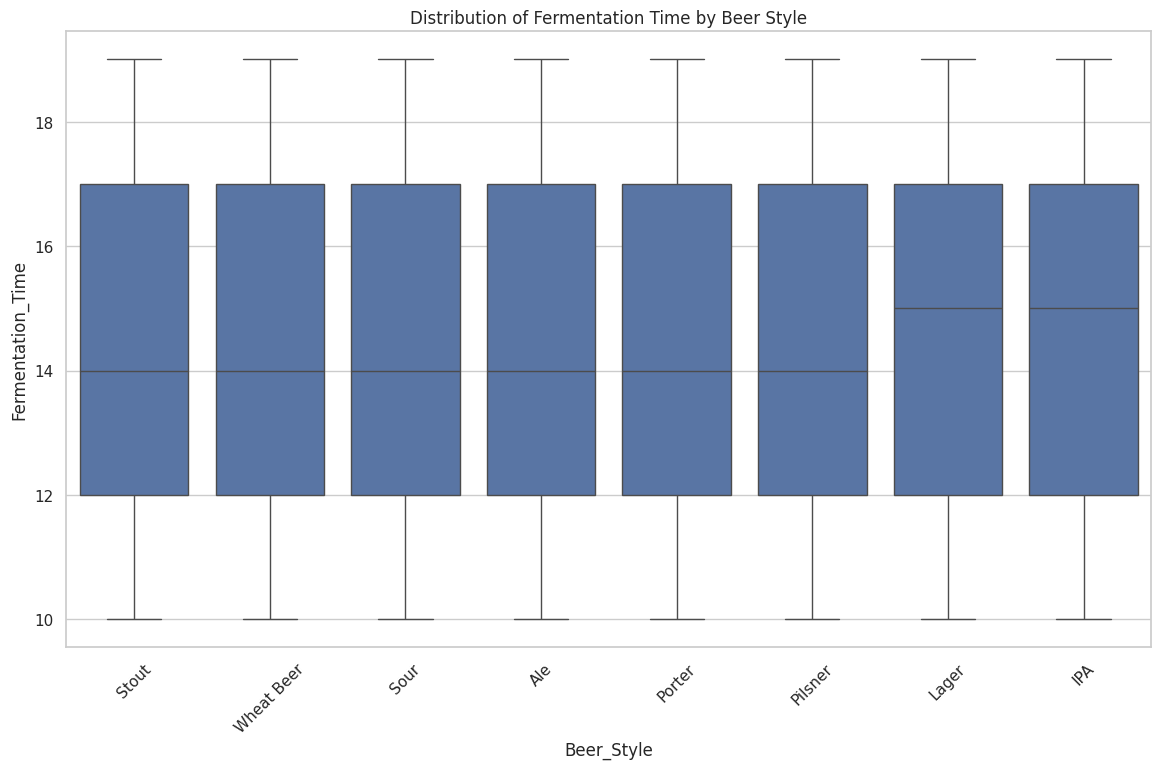

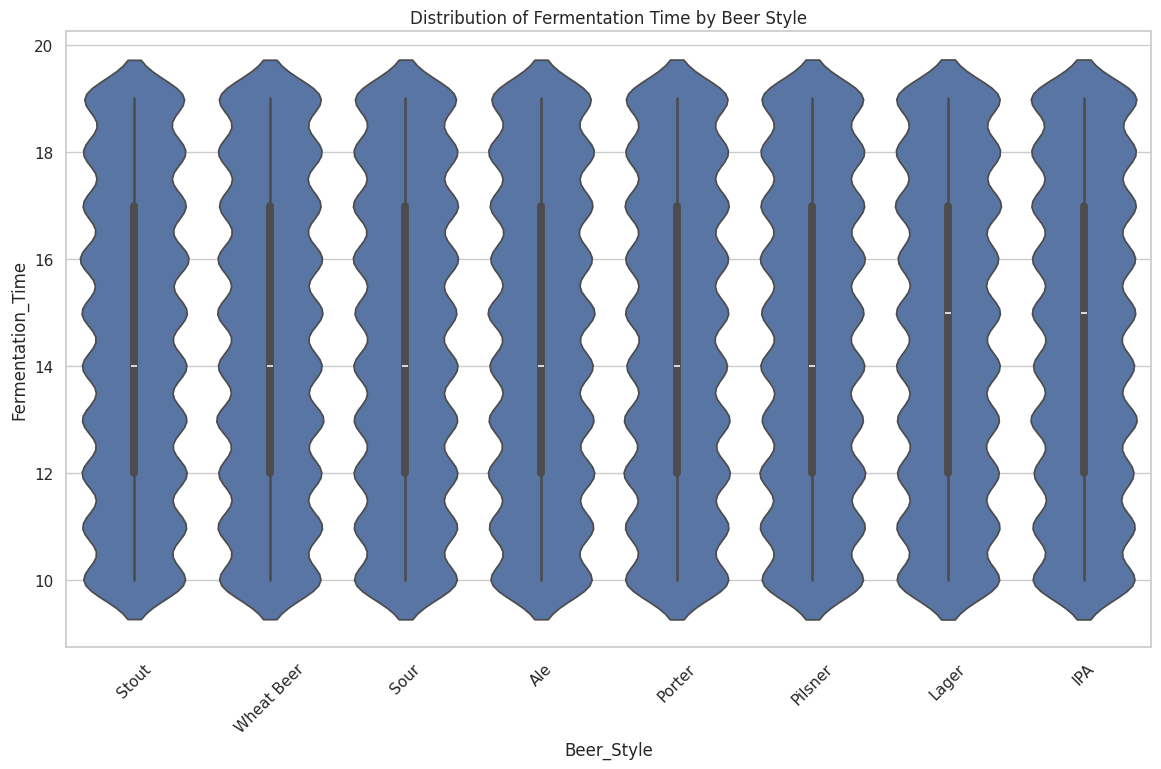

Data transformation execution time: 5.14 seconds


In [26]:
# Start the timer
start_time = time.time()

# Extract relevant columns
ferment_style_comp = beer_quality_predict.select('Beer_Style', 'Fermentation_Time')

# Convert to Pandas DataFrame for plotting
ferment_style_comp_pd = ferment_style_comp.toPandas()

# Create a box plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Beer_Style', y='Fermentation_Time', data=ferment_style_comp_pd)
plt.title('Distribution of Fermentation Time by Beer Style')
plt.xticks(rotation=45)
plt.show()

# Create a violin plot
plt.figure(figsize=(14, 8))
sns.violinplot(x='Beer_Style', y='Fermentation_Time', data=ferment_style_comp_pd)
plt.title('Distribution of Fermentation Time by Beer Style')
plt.xticks(rotation=45)
plt.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

This very discrete data is based on 250,000 data points and shows that Lager and IPA have an increased fermentation time... add in why due to chemistry.

Next, let's see if any of the data can be clustered with a K-means experiment. To determine the optimal cluster grouping number inertia and silhouette scores will be used.

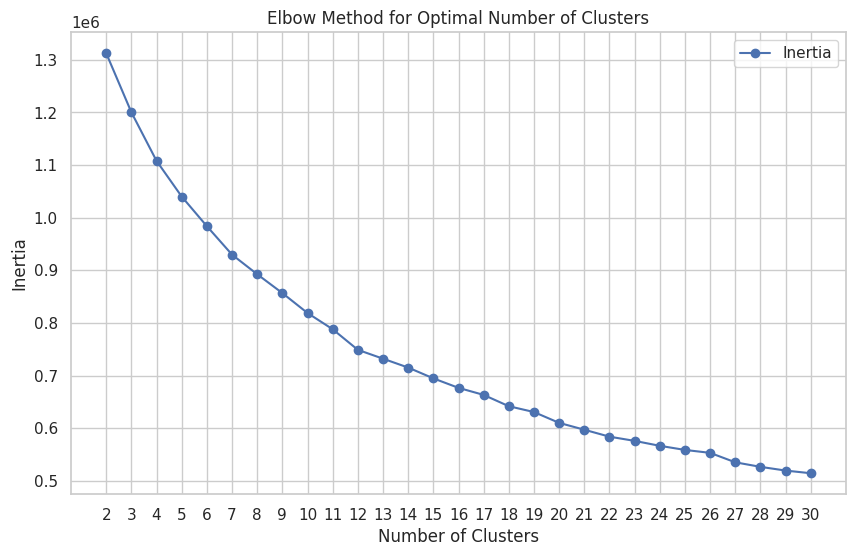

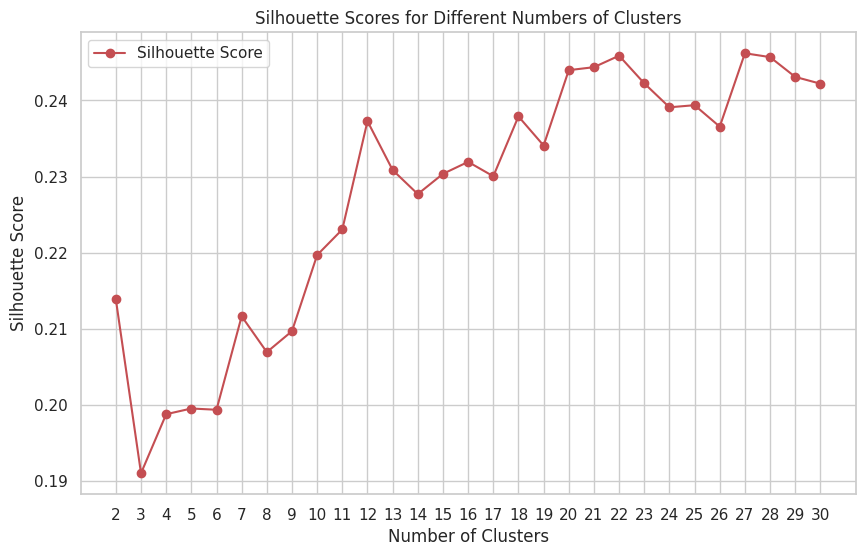

Data transformation execution time: 903.13 seconds


In [27]:
# Select relevant features for clustering
clustering_features = ['Temperature', 'Fermentation_Time', 'pH_Level', 'Alcohol_Content', 'Bitterness', 'Color']

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=clustering_features, outputCol="features")
beer_assembled = assembler.transform(beer_encoded)

# Normalize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(beer_assembled)
beer_scaled = scaler_model.transform(beer_assembled)

# Define the range of clusters to test
min_clusters = 2
max_clusters = 30

# Store inertia and silhouette scores for different cluster sizes
inertia_values = []
silhouette_scores = []

# ClusteringEvaluator to calculate silhouette scores
evaluator = ClusteringEvaluator(featuresCol='scaled_features', metricName='silhouette', distanceMeasure='squaredEuclidean')

# Iterate over the range of clusters
for k_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(k=k_clusters, seed=42, featuresCol="scaled_features")
    kmeans_model = kmeans.fit(beer_scaled)

    # Make predictions
    predictions = kmeans_model.transform(beer_scaled)

    # Append inertia (sum of squared distances to nearest cluster center)
    inertia_values.append(kmeans_model.summary.trainingCost)

    # Calculate silhouette score
    silhouette_avg = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_avg)

# Plot the inertia values to visualize the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(min_clusters, max_clusters + 1), inertia_values, marker='o', linestyle='-', color='b', label='Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(min_clusters, max_clusters + 1))
plt.grid(True)
plt.legend()
plt.show()

# Plot the silhouette scores to further validate the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='-', color='r', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xticks(range(2, max_clusters + 1))
plt.grid(True)
plt.legend()
plt.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


27 is the optimal number of clusters. The Inertia score shows a leveling off of(plateau of a low point? term for this?) the values after 27 and the Silhouette score shows a peak at 27. The calculations support each other and the determination that 27 is the optimal number of clusters.

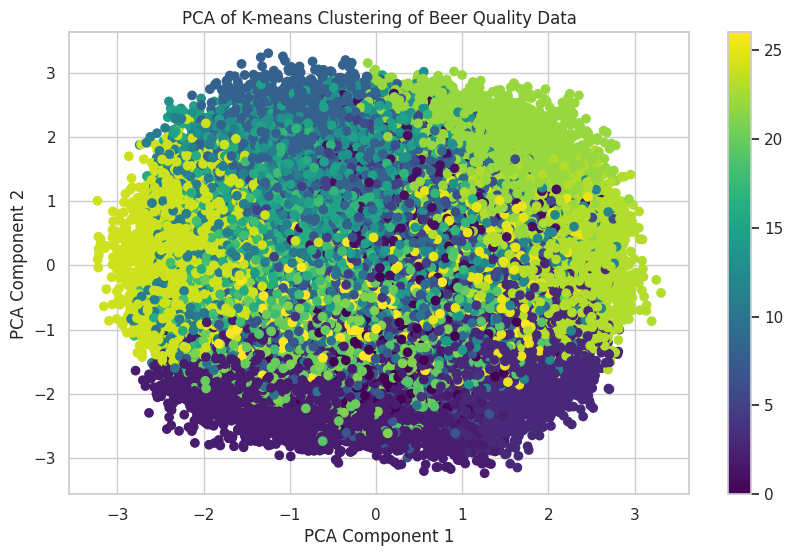

Data transformation execution time: 951.47 seconds


In [28]:
# # Start the timer
# start_time = time.time()

# Select relevant features for clustering
clustering_features = ['Temperature', 'Fermentation_Time', 'pH_Level', 'Alcohol_Content', 'Bitterness', 'Color']

# VectorAssembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=clustering_features, outputCol='features')
beer_assembled = assembler.transform(beer_encoded)

# Normalize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(beer_assembled)
beer_scaled = scaler_model.transform(beer_assembled)

# Apply KMeans clustering
num_clusters = 27  # Specify the number of clusters
kmeans = KMeans(k=num_clusters, seed=42, featuresCol='scaled_features', predictionCol='Cluster')
kmeans_model = kmeans.fit(beer_scaled)
beer_clustered = kmeans_model.transform(beer_scaled)

# Apply PCA
pca = PCA(k=2, inputCol="scaled_features", outputCol="pcaFeatures")
pca_model = pca.fit(beer_clustered)
beer_pca = pca_model.transform(beer_clustered)

# Convert to Pandas for visualization
beer_pca_pd = beer_pca.select("pcaFeatures", "Cluster").toPandas()
beer_pca_pd[['pca1', 'pca2']] = pd.DataFrame(beer_pca_pd['pcaFeatures'].tolist(), index=beer_pca_pd.index)

# Plot the PCA results with clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(beer_pca_pd['pca1'], beer_pca_pd['pca2'], c=beer_pca_pd['Cluster'], cmap="viridis")
plt.colorbar(scatter)
plt.title('PCA of K-means Clustering of Beer Quality Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

PCA (faster) vs TSNE (slower, why does this one seem to have more distinct clusters while PCA has more discrete dots) - explain why what aspects of the data does each of the two algorithms take into account.

k means is only with the numerical variables relative to each other. Categorical doesn't imply order so may produce unreliable or misleading information. Could do some special treatment for combining such data - research a strategy for how that could be done in the future.

on such flat and uniform data it is nice to finally see some results that could lead to more understanding.

In [33]:
cluster_medians.show(28)



+-------+--------------------+
|Cluster|median_Quality_Score|
+-------+--------------------+
|      3|   7.998313568628878|
|      4|    7.98494539937613|
|      8|   8.004249051464601|
|     20|   7.996813960220367|
|     23|   8.027925047409536|
|      7|   8.014161155109251|
|     11|   9.999674912618174|
|      5|  7.9978851611169075|
|     14|   8.024862848733997|
|     26|   7.998647669742768|
|     19|   7.978017523049981|
|     10|   7.989558426569811|
|      2|   7.991218757089468|
|     12|    9.99964622869868|
|     15|   8.007396771053553|
|     22|  7.9968600811374175|
|     25|  7.9881056571714195|
|     24|   9.999603668752092|
|      9|   7.979749994791563|
|     17|   8.024402404710237|
|      0|   8.002263232675585|
|     18|   8.033309726472943|
|     21|   7.998978208965976|
|      1|   7.984808900305449|
|     13|  7.9970881985137785|
|     16|   8.031737363867629|
|      6|   9.999222105648117|
+-------+--------------------+



In [35]:
print(cluster_order)
beer_clustered.select('Cluster', 'Cluster_Order').distinct().show(28)


[19, 9, 1, 4, 25, 10, 2, 20, 22, 13, 5, 3, 26, 21, 0, 8, 15, 7, 17, 14, 23, 16, 18, 6, 24, 12, 11]
+-------+-------------+
|Cluster|Cluster_Order|
+-------+-------------+
|     14|           19|
|     18|           22|
|      3|           11|
|     22|            8|
|     21|           13|
|      7|           17|
|     11|           26|
|     12|           25|
|      5|           10|
|      1|            2|
|      0|           14|
|     24|           24|
|      9|            1|
|     23|           20|
|     19|            0|
|     15|           16|
|     20|            7|
|     13|            9|
|     26|           12|
|      8|           15|
|     16|           21|
|     25|            4|
|      4|            3|
|      6|           23|
|     10|            5|
|      2|            6|
|     17|           18|
+-------+-------------+



the clustering order doesn't seem to be working

<ipython-input-30-3113e1c4628b>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette='viridis')


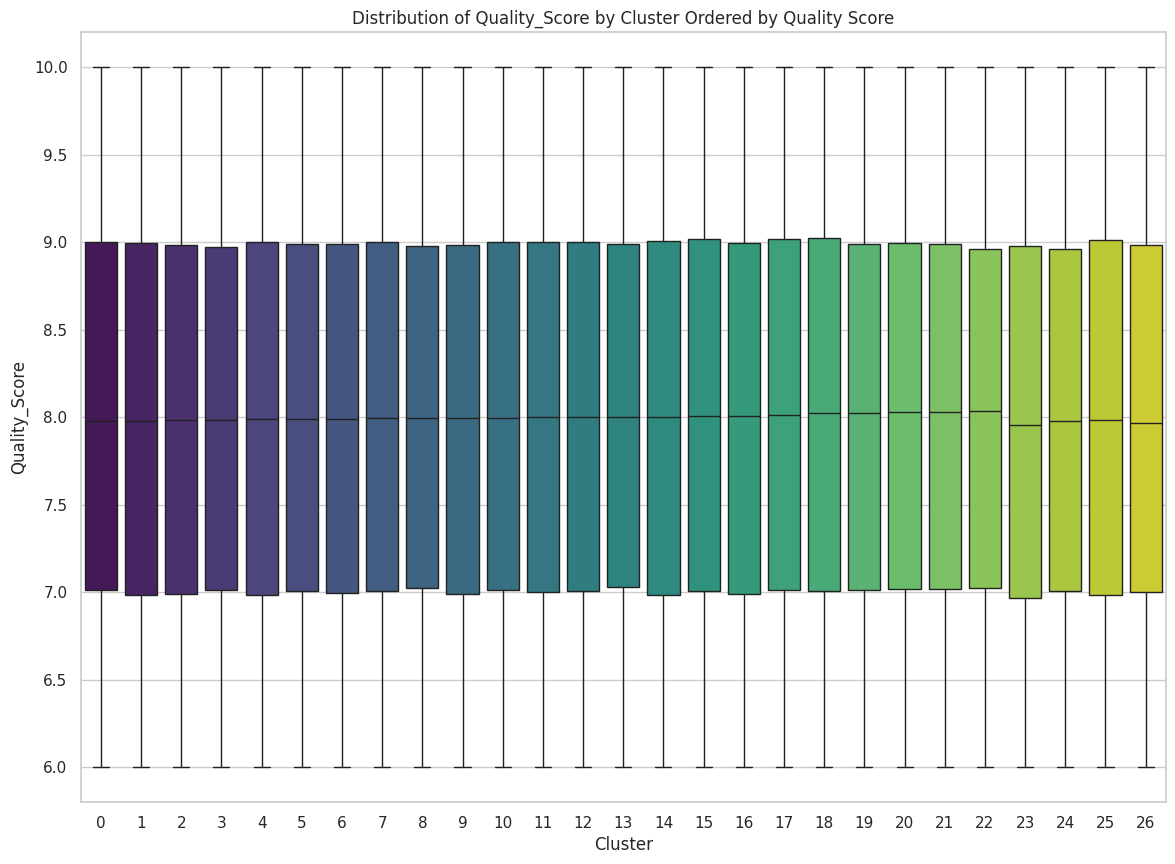

<ipython-input-30-3113e1c4628b>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette='viridis')


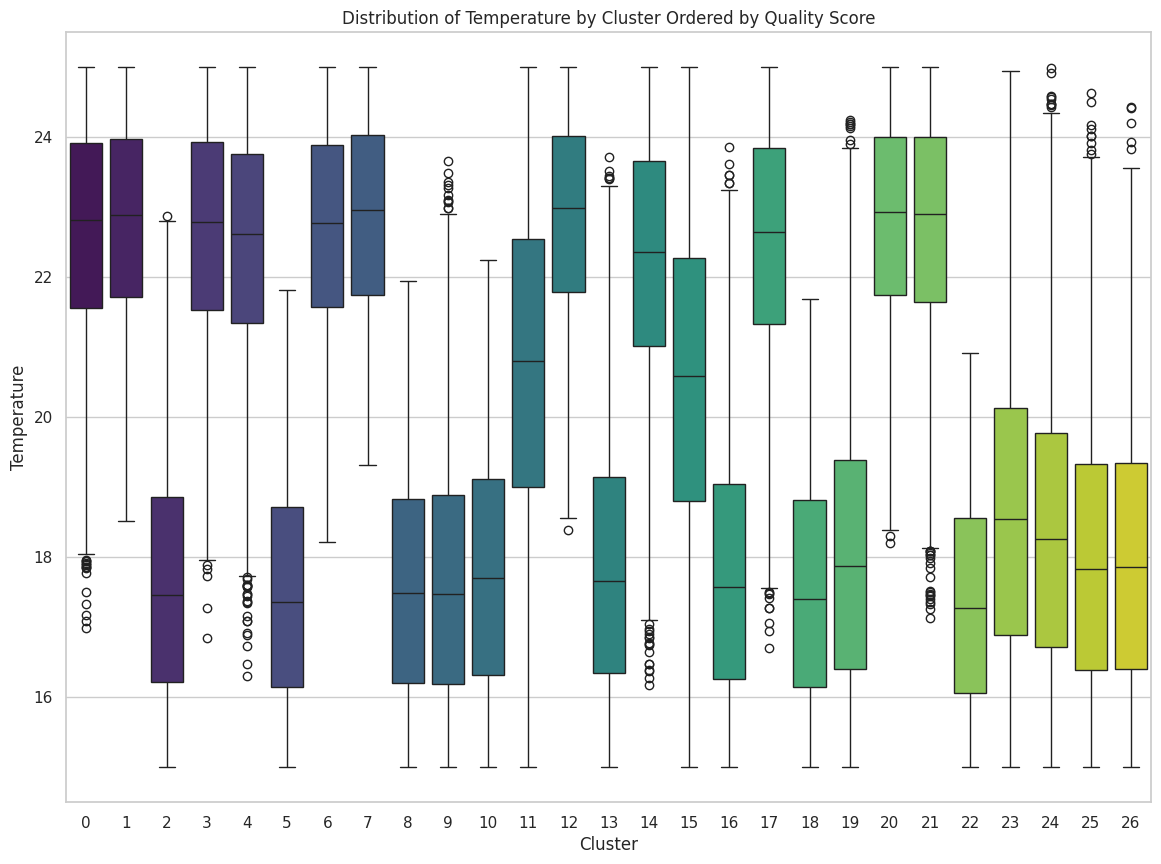

<ipython-input-30-3113e1c4628b>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette='viridis')


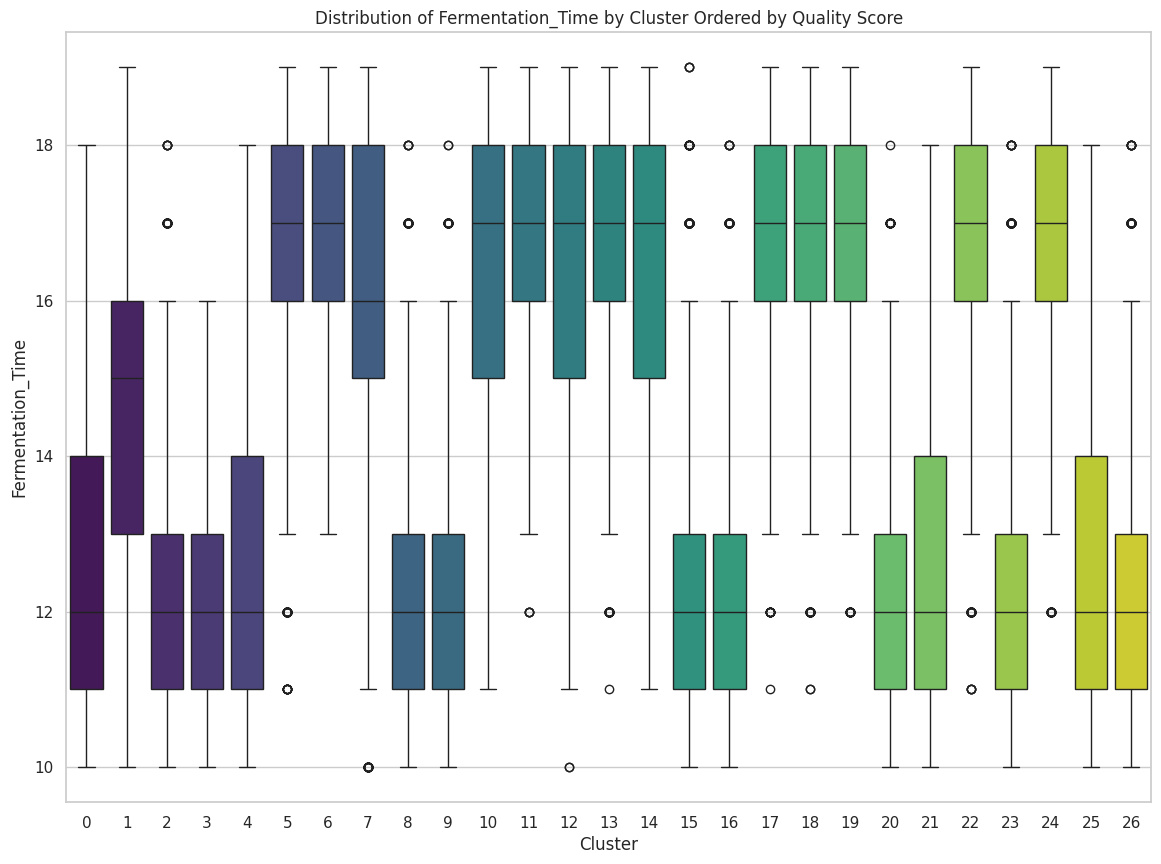

<ipython-input-30-3113e1c4628b>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette='viridis')


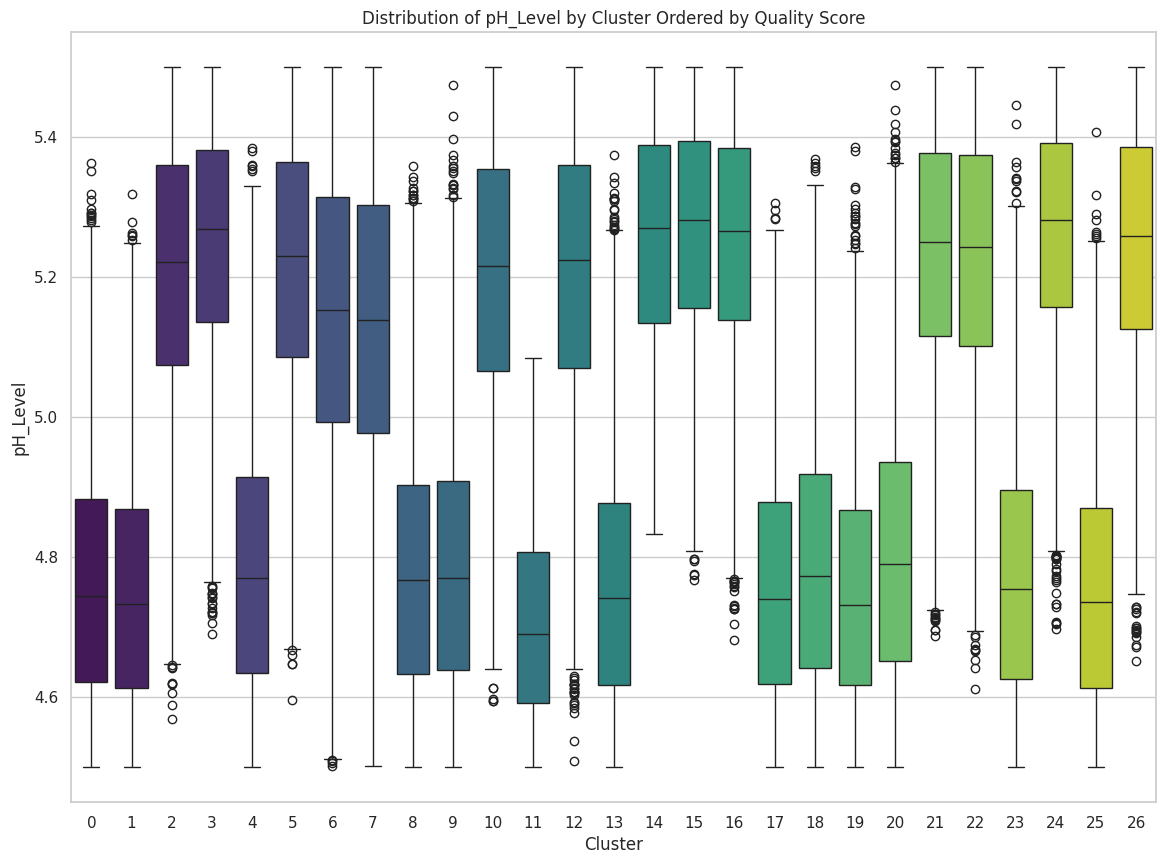

<ipython-input-30-3113e1c4628b>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette='viridis')


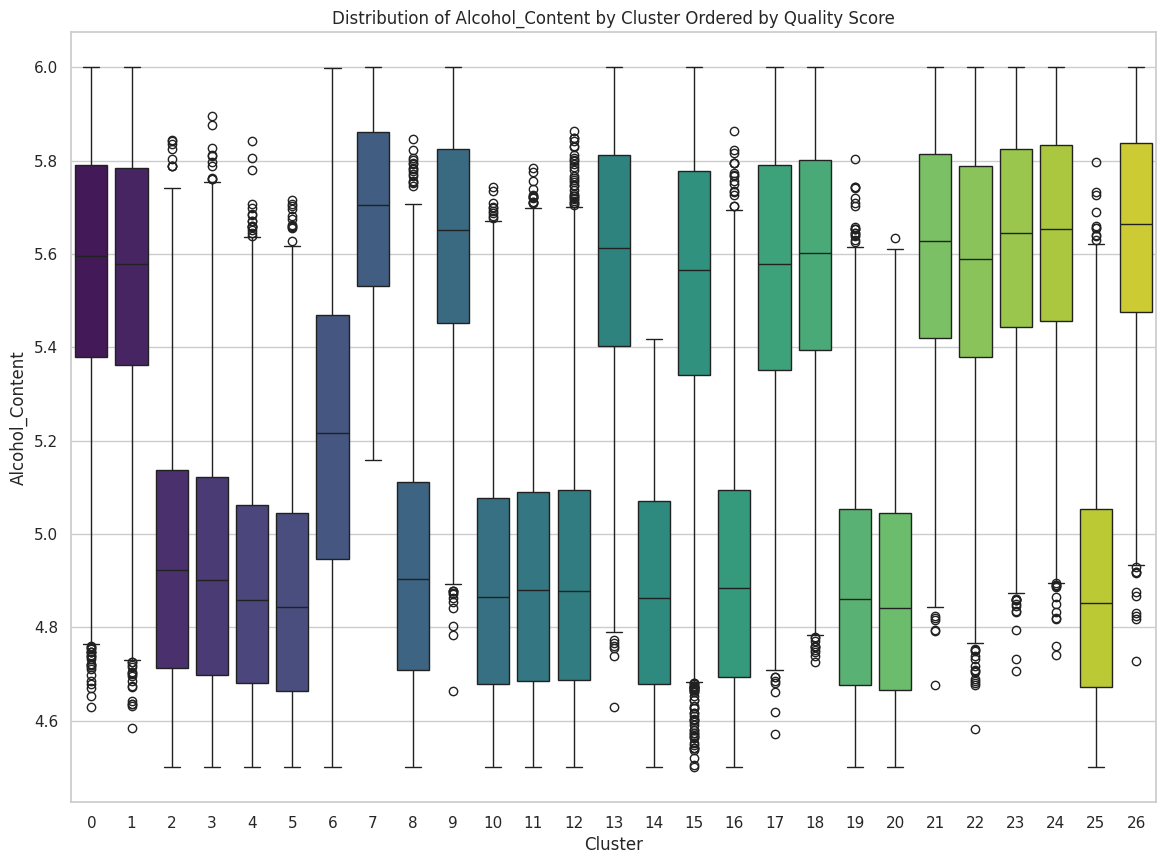

<ipython-input-30-3113e1c4628b>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette='viridis')


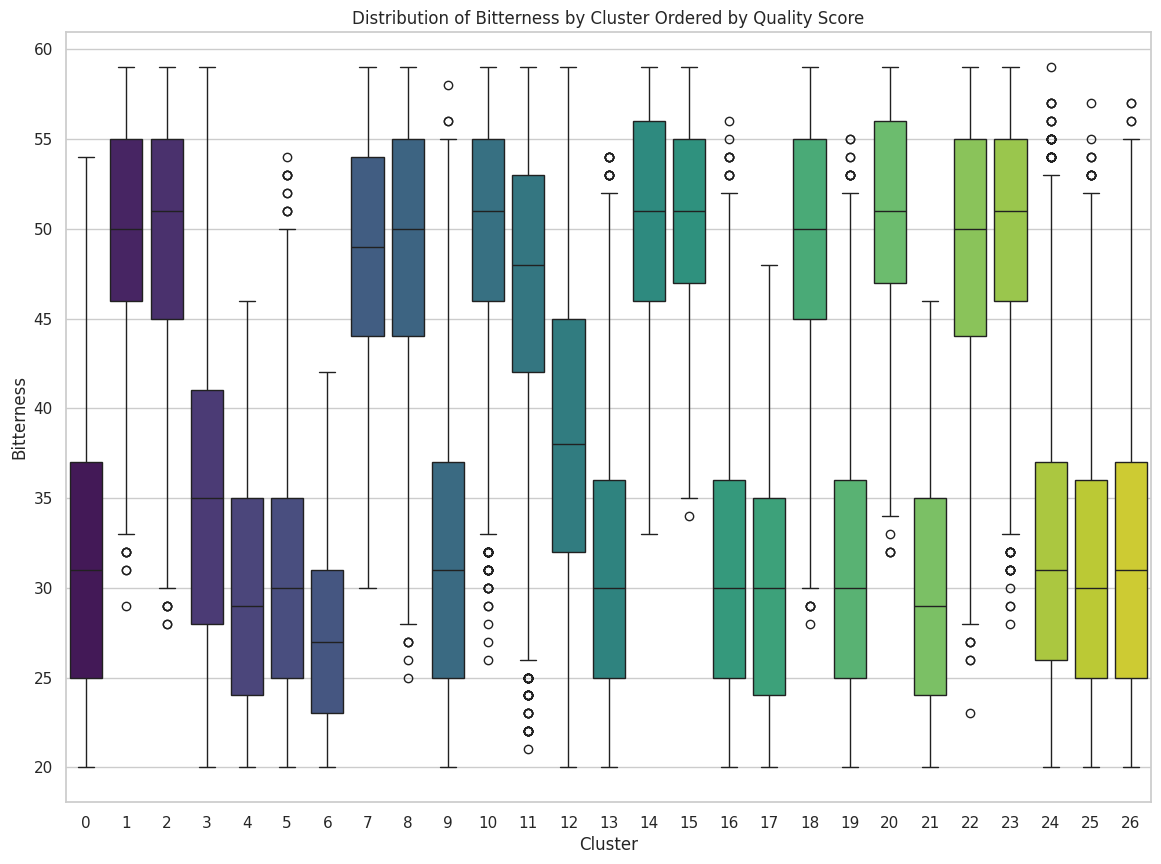

<ipython-input-30-3113e1c4628b>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette='viridis')


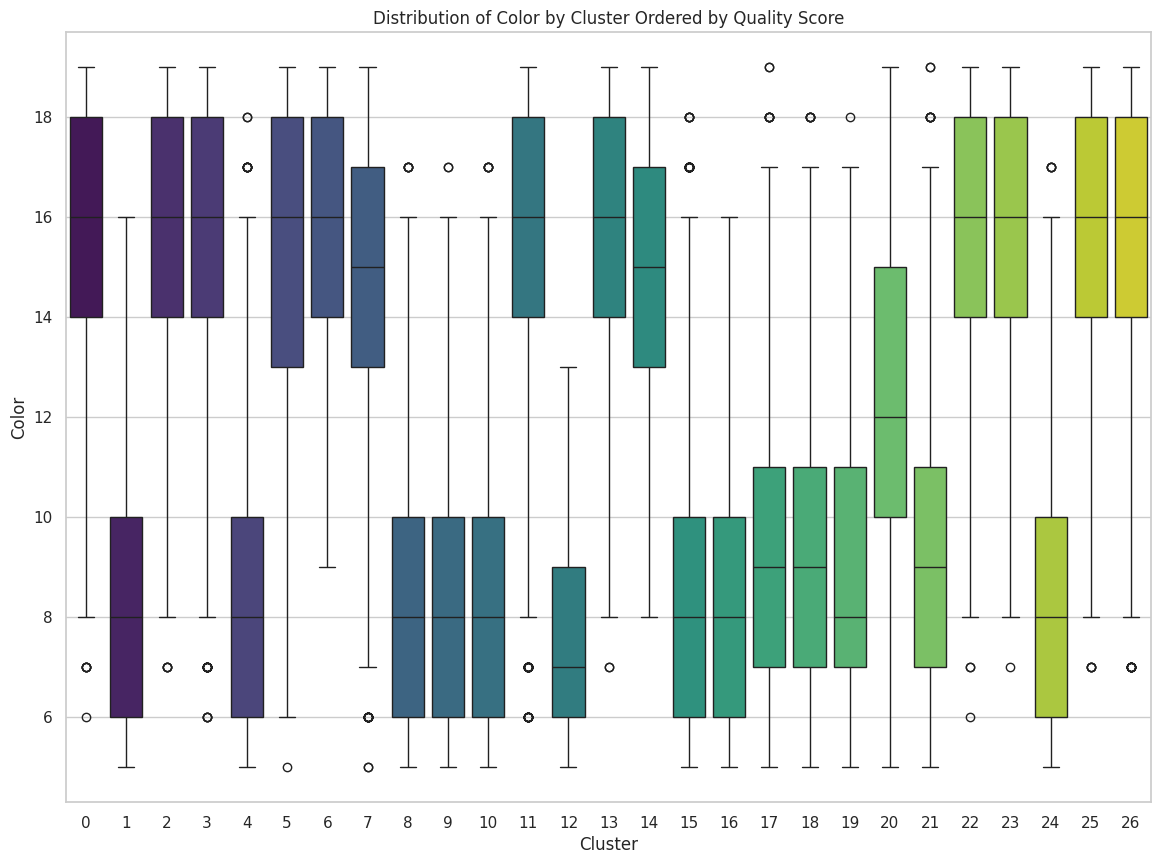

Data transformation execution time: 84.44 seconds


In [30]:
# Start the timer
start_time = time.time()

# Calculate the median quality score for each cluster
cluster_medians = beer_clustered.groupBy('Cluster').agg(expr('percentile_approx(Quality_Score, 0.5)').alias('median_Quality_Score'))
cluster_order = [row['Cluster'] for row in cluster_medians.orderBy('median_Quality_Score').collect()]

# Create a new column 'Cluster_Order' with the ordered cluster categories
cluster_mapping_expr = when(col('Cluster') == cluster_order[0], lit(0))
for i, cluster in enumerate(cluster_order[1:], 1):
    cluster_mapping_expr = cluster_mapping_expr.when(col('Cluster') == cluster, lit(i))

beer_clustered = beer_clustered.withColumn('Cluster_Order', cluster_mapping_expr)

# Convert the 'Cluster_Order' column to integer type
beer_clustered = beer_clustered.withColumn('Cluster_Order', col('Cluster_Order').cast('int'))

# Convert the DataFrame to Pandas for plotting
beer_clustered_pd = beer_clustered.toPandas()

# Ensure the DataFrame is sorted by Cluster_Order
beer_clustered_pd = beer_clustered_pd.sort_values(by='Cluster_Order') #doesn't seem to be working

# Generate a palette based on the custom colormap for the clusters
#cluster_palette = sns.color_palette([srm_colors_custom.get(c, "#000000") for c in sorted(beer_clustered_pd['Cluster_Order'].unique())])

# Plot the box plots using the ordered clusters
features_to_plot = ['Quality_Score', 'Temperature', 'Fermentation_Time', 'pH_Level', 'Alcohol_Content', 'Bitterness', 'Color']

for feature in features_to_plot:
    plt.figure(figsize=(14, 10))
    sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette='viridis')
    plt.title(f'Distribution of {feature} by Cluster Ordered by Quality Score')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

The clusters were ordered by the median beer quality to visually and comparibly order the cluters to potentially separate any clusters that showed either remarkable qualities or completely undesirable qualities.

Generally, the feature distributions by cluster ordered by quality score showed a bimodal distribution. Possibly
 indicating that some more structure in the data is becoming visable. two color families, etc... natural variation, noise, beer families, ...

put the chemy py stuff here - derived data- add column and run training models. Arguments can be made to add this in earlier or later. For this project, because it's a derived and not raw data, it will be included only for the ML and NN models.

In [36]:
# Start the timer
start_time = time.time()

# Display the schema of the DataFrame
beer_encoded.printSchema()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

root
 |-- pH_Level: double (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Fermentation_Time: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: integer (nullable = true)
 |-- Color: integer (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- Water_Ratio: double (nullable = false)
 |-- Malt_Ratio: float (nullable = true)
 |-- Hops_Ratio: float (nullable = true)
 |-- Malt_Hops_Ratio: double (nullable = true)
 |-- Malt_Type: string (nullable = false)
 |-- Hops_Type: string (nullable = false)
 |-- Beer_Style_Index: double (nullable = false)
 |-- Beer_Style_Vec: vector (nullable = true)
 |-- Malt_Type_Index: double (nullable = false)
 |-- Malt_Type_Vec: vector (nullable = true)
 |-- Hops_Type_Index: double (nullable = false)
 |-- Hops_Type_Vec: vector (nullable = true)

Data transformation execution time: 0.00 seconds


In [37]:
# Start the timer
start_time = time.time()

# Sample 10% of the rows with a seed for reproducibility
beer_encoded_sampled = beer_encoded.sample(withReplacement=False, fraction=0.10, seed=42)

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

Data transformation execution time: 0.02 seconds


resources to process all of the sample data set with kmeans was available. The modeling is a more resource intensive process and so the data was further subsampled.

These next experiments utilize both the numeric and encoded categorical data.

In [38]:
beer_encoded_sampled.show()


+------------------+----------------+-----------------+------------------+------------------+----------+-----+-----------------+----------+-----------+----------+----------+------------------+---------+------------+----------------+--------------+---------------+-------------+---------------+-------------+
|          pH_Level|Ingredient_Ratio|Fermentation_Time|       Temperature|   Alcohol_Content|Bitterness|Color|    Quality_Score|Beer_Style|Water_Ratio|Malt_Ratio|Hops_Ratio|   Malt_Hops_Ratio|Malt_Type|   Hops_Type|Beer_Style_Index|Beer_Style_Vec|Malt_Type_Index|Malt_Type_Vec|Hops_Type_Index|Hops_Type_Vec|
+------------------+----------------+-----------------+------------------+------------------+----------+-----+-----------------+----------+-----------+----------+----------+------------------+---------+------------+----------------+--------------+---------------+-------------+---------------+-------------+
|5.4555000887623075|     1:0.30:0.30|               12|16.270818490984684| 5

In [39]:
# Start the timer
start_time = time.time()

# Define the feature columns
feature_columns = ['Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature',
                   'Alcohol_Content', 'Bitterness', 'Color', 'Beer_Style_Index', 'Malt_Type_Index',
                   'Hops_Type_Index']

# Assemble the feature columns into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
beer_encoded_sampled_vectorized = assembler.transform(beer_encoded_sampled)

# Select the features and label columns
data = beer_encoded_sampled_vectorized.select("features", col("Quality_Score").alias("label"))

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Print the count of rows in the training and testing sets
print(f"Training set size: {train_data.count()}")
print(f"Test set size: {test_data.count()}")

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


Training set size: 20076
Test set size: 4902
Data transformation execution time: 6.18 seconds


random seed to keep reproducible experiment. All features here are put into one big vector. row with 10 columns vs a vector with 10 dimenstions - a different 'packaging' of the data.(spark thing)

In [40]:
# Start the timer
start_time = time.time()

# Define the RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol='label', seed=42)

# Define the parameter grid (reduced size for testing)
#paramGrid = ParamGridBuilder() \
#    .addGrid(rf.numTrees, [50, 100]) \
#    .addGrid(rf.maxDepth, [5, 10]) \
#    .addGrid(rf.minInstancesPerNode, [1]) \
#    .build()

# Define the parameter grid (reduced size for testing)
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 500, 1500]) \
    .addGrid(rf.maxDepth, [5]) \
    .addGrid(rf.minInstancesPerNode, [1, 2]) \
    .build()

# Define the parameter grid (testing progression to get an r value greater than zero)
#paramGrid = ParamGridBuilder() \
   #.addGrid(rf.numTrees, [50, 1000, 10000]) \ # 1 million data points; how many trees needed would be expected to perform well (less number of data points, same, or more?1,000 then 10,000)
   #.addGrid(rf.maxDepth, [5, 30]) \  # 10, 50, 100, 200
   #.addGrid(rf.minInstancesPerNode, [1, 2]) \  # 1, 2, 10
   #.build()

#see if there are any other parameters that need to be tuned: criterion

# Define the evaluator
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')

# Define the CrossValidator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3,
                          parallelism=2)  # Reduced parallelism for limited resources

# Fit the model
cvModel = crossval.fit(train_data)

# Get the best model
best_rf_model = cvModel.bestModel

# Print all parameters and their values for the best model
print(best_rf_model.explainParams())

# Predict on the test set
predictions = best_rf_model.transform(test_data)

# Evaluate the best model on the test set
r2_score_best = evaluator.evaluate(predictions)
print(f"R^2 score of the best model: {r2_score_best}")

# Feature importances
importances = best_rf_model.featureImportances

# Convert feature importances to a pandas DataFrame
importances_df = pd.DataFrame(importances.toArray(), index=feature_columns, columns=['Importance'])

# Plot the feature importances
plt.figure(figsize=(14, 8))
importances_df.sort_values(by='Importance', ascending=False).plot(kind='bar')
plt.title('Feature Importances from Random Forest')
plt.ylabel('Importance Score')
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


KeyboardInterrupt: 

positive r^2 score, time it took to run, top 3 features

print the top RF paramteres...

In [41]:
# Start the timer
start_time = time.time()

# Split the data into training and testing sets
train_data, test_data = beer_encoded_sampled_vectorized.randomSplit([0.8, 0.2], seed=42)

# Initialize the Gradient Boosting Regressor
gbr = GBTRegressor(featuresCol="features", labelCol="Quality_Score", seed=42)

# Define the parameter grid (baseline)
paramGrid = ParamGridBuilder() \
    .addGrid(gbr.maxIter, [100, 200]) \
    .addGrid(gbr.maxDepth, [3, 4]) \
    .addGrid(gbr.stepSize, [0.01, 0.05]) \
    .build()

# Define the parameter grid (advanced)
#paramGrid = ParamGridBuilder() \
#    .addGrid(gbr.maxIter, [100, 200, 300]) \
#    .addGrid(gbr.maxDepth, [3, 4, 5]) \
#    .addGrid(gbr.stepSize, [0.01, 0.05, 0.1]) \
#    .build()

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="Quality_Score", predictionCol="prediction", metricName="r2")

# Initialize CrossValidator
crossval = CrossValidator(estimator=gbr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3,
                          parallelism=4)

# Fit the model
cvModel = crossval.fit(train_data)

# Get the best model
best_gbr_model = cvModel.bestModel

# Print all parameters and their values for the best model
print(best_gbr_model.explainParams())

# Predict on the test set
predictions = best_gbr_model.transform(test_data)

# Evaluate the model
r2_score_best = evaluator.evaluate(predictions)
print(f"R^2 score of the best Gradient Boosting model: {r2_score_best}")

# Feature importances
importances = best_gbr_model.featureImportances

# Plot feature importances
# Convert feature importances to a pandas DataFrame
importances_gbr = pd.DataFrame(importances.toArray(), index=feature_columns, columns=['Importance'])

# Plot the feature importances
plt.figure(figsize=(14, 8))
importances_gbr.sort_values(by='Importance', ascending=False).plot(kind='bar')
plt.title('Feature Importances from Gradient Boosting Regressor')
plt.ylabel('Importance Score')
plt.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

KeyboardInterrupt: 

negative r^2 score, time it took to run, top 3 features

mentoin top parameters

## deep dive content

looking at derived pH data, water ius the most important variable. determine initial pH, talk about buffers and how they work in beer anbd can impact quality score.

In [42]:
# Show the total number of rows in the DataFrame
total_rows = beer_encoded_sampled.count()
print(f"Total number of rows: {total_rows}")

# Show the first few rows to verify the data
beer_encoded_sampled.show(5)


Total number of rows: 24978
+------------------+----------------+-----------------+------------------+-----------------+----------+-----+-----------------+----------+-----------+----------+----------+------------------+---------+------------+----------------+--------------+---------------+-------------+---------------+-------------+
|          pH_Level|Ingredient_Ratio|Fermentation_Time|       Temperature|  Alcohol_Content|Bitterness|Color|    Quality_Score|Beer_Style|Water_Ratio|Malt_Ratio|Hops_Ratio|   Malt_Hops_Ratio|Malt_Type|   Hops_Type|Beer_Style_Index|Beer_Style_Vec|Malt_Type_Index|Malt_Type_Vec|Hops_Type_Index|Hops_Type_Vec|
+------------------+----------------+-----------------+------------------+-----------------+----------+-----+-----------------+----------+-----------+----------+----------+------------------+---------+------------+----------------+--------------+---------------+-------------+---------------+-------------+
|5.4555000887623075|     1:0.30:0.30|              

why were some rows dropped? why not 25,000?

In [43]:
#debug 6
#debug 4
from collections import defaultdict
from chempy import Equilibrium, Substance
from chempy.chemistry import Species
from chempy.equilibria import EqSystem
from scipy.optimize import fsolve
from math import log10
import numpy as np

# Define buffer capacities
malt_buffer_capacities = {
    'Barley': 0.1,
    'Wheat': 0.2,
    'Rye': 0.15,
    'Oats': 0.05
}

hops_buffer_capacities = {
    'Bittering': 0.2,
    'Dual Purpose': 0.1,
    'Aroma': 0.05
}

# Define the buffer system function for PySpark
def buffer_system_with_types_spark(final_pH, malt_type, hops_type, malt_ratio, hops_ratio):
    try:
        print(f"Processing row with: final_pH={final_pH}, malt_type={malt_type}, hops_type={hops_type}, malt_ratio={malt_ratio}, hops_ratio={hops_ratio}")

        # Phosphate buffer example
        H2PO4 = Species.from_formula('H2PO4-')
        HPO4 = Species.from_formula('HPO4-2')
        H = Species.from_formula('H+')
        OH = Species.from_formula('OH-')
        H2O = Species.from_formula('H2O')

        phosphate_buffer = Equilibrium({'H2PO4-'}, {'H+', 'HPO4-2'}, 10**-7.2)
        water_autop = Equilibrium({'H2O'}, {'H+', 'OH-'}, 10**-14)
        substances = [H2O, OH, H, H2PO4, HPO4]

        eqsys = EqSystem([phosphate_buffer, water_autop], substances)

        # Get buffering capacities based on malt and hops types
        malt_buffer = malt_buffer_capacities.get(malt_type, 0.1)
        hops_buffer = hops_buffer_capacities.get(hops_type, 0.1)

        concentrations = defaultdict(float, {
            'H2PO4-': malt_ratio * malt_buffer,
            'HPO4-2': hops_ratio * hops_buffer,
            'H2O': 1.0
        })

        print("Concentrations:", concentrations)

        def residual(H_conc):
            concentrations['H+'] = H_conc[0]
            arr, sol, sane = eqsys.root(concentrations)
            conc = dict(zip(eqsys.substances, arr))
            return conc['H+'] - H_conc[0]

        H_initial, = fsolve(residual, [10**-final_pH])
        initial_pH = -log10(H_initial)

        print(f"Initial pH: {initial_pH}")

        return float(initial_pH)
    except Exception as e:
        print(f"Error in buffer_system_with_types_spark: {e}")
        return None

# Register the UDF (user-defined function)
buffer_system_udf = udf(buffer_system_with_types_spark, DoubleType())

# Apply UDF to DataFrame with inferred malt and hops types
beer_encoded_sampled = beer_encoded_sampled.withColumn(
    'Estimated_Initial_pH',
    buffer_system_udf(
        col('pH_Level'),
        col('Malt_Type'),
        col('Hops_Type'),
        col('Malt_Ratio'),
        col('Hops_Ratio')
    )
)

# Print the first 5 rows of the Estimated_Initial_pH column
beer_encoded_sampled.select('Estimated_Initial_pH').show(5)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


KeyboardInterrupt: 

In [ ]:
#Debug 4 6
# Convert to Pandas DataFrame for visualization
beer_encoded_sampled_pd = beer_encoded_sampled.toPandas()

# Check for NaN values and remove them
print("Checking for NaN values in the 'Estimated_Initial_pH' column")
nan_count = beer_encoded_sampled_pd['Estimated_Initial_pH'].isna().sum()
print(f"Number of NaN values: {nan_count}")

# Print rows with NaN values for inspection
if nan_count > 0:
    print("Rows with NaN values:")
    print(beer_encoded_sampled_pd[beer_encoded_sampled_pd['Estimated_Initial_pH'].isna()])

# Drop rows with NaN values in 'Estimated_Initial_pH' or 'Quality_Score'
#beer_encoded_sampled_pd.dropna(subset=['Estimated_Initial_pH', 'Quality_Score'], inplace=True)

# Visualize the results
plt.figure(figsize=(10, 6))
sns.boxplot(x='Quality_Score', y='Estimated_Initial_pH', data=beer_encoded_sampled_pd)
plt.title('Estimated Initial pH Impact on Beer Quality')
plt.xlabel('Quality Score')
plt.ylabel('Estimated Initial pH')
plt.show()

In [ ]:
# Create a simple equilibrium
eq = Equilibrium({'A': 1}, {'B': 1}, 10)

# Print the attributes of the Equilibrium object
print(dir(eq))
import chempy
print(chempy.__version__)

In [ ]:
#debug 5
from chempy import Equilibrium, Species
from chempy.equilibria import EqSystem
from collections import defaultdict
from scipy.optimize import fsolve
import numpy as np

# Define buffer capacities
malt_buffer_capacities = {
    'Barley': 0.1,
    'Wheat': 0.2,
    'Rye': 0.15,
    'Oats': 0.05
}

hops_buffer_capacities = {
    'Bittering': 0.2,
    'Dual Purpose': 0.1,
    'Aroma': 0.05
}

# Define the buffer system function for PySpark
def buffer_system_with_types_spark(final_pH, malt_type, hops_type, malt_ratio, hops_ratio):
    try:
        print(f"Processing row with: final_pH={final_pH}, malt_type={malt_type}, hops_type={hops_type}, malt_ratio={malt_ratio}, hops_ratio={hops_ratio}")

        # Define species
        H3PO4 = Species('H3PO4', latex_name='H_{3}PO_{4}')
        H2PO4 = Species('H2PO4-', latex_name='H_{2}PO_{4}^{-}', charge=-1)
        HPO4 = Species('HPO4-2', latex_name='HPO_{4}^{2-}', charge=-2)
        PO4 = Species('PO4-3', latex_name='PO_{4}^{3-}', charge=-3)
        H = Species('H+', latex_name='H^{+}', charge=1)
        OH = Species('OH-', latex_name='OH^{-}', charge=-1)
        H2O = Species('H2O', latex_name='H_{2}O')

        # Define equilibria
        eq1 = Equilibrium({'H2PO4-': 1}, {'H+': 1, 'HPO4-2': 1}, 10**-7.2)  # pKa = 7.2
        eq2 = Equilibrium({'H2O': 1}, {'H+': 1, 'OH-': 1}, 10**-14)  # Water auto-ionization
        eq3 = Equilibrium({'H3PO4': 1}, {'H+': 1, 'H2PO4-': 1}, 10**-2.15)  # pKa1 = 2.15
        eq4 = Equilibrium({'HPO4-2': 1}, {'H+': 1, 'PO4-3': 1}, 10**-12.3)  # pKa3 = 12.3

        # Create equilibrium system
        eqsys = EqSystem([eq1, eq2, eq3, eq4], [H3PO4, H2PO4, HPO4, PO4, H, OH, H2O])

        # Get buffering capacities based on malt and hops types
        malt_buffer = malt_buffer_capacities.get(malt_type, 0.1)
        hops_buffer = hops_buffer_capacities.get(hops_type, 0.1)

        # Define initial concentrations
        init_conc = defaultdict(float, {
            'H2PO4-': malt_ratio * malt_buffer,
            'HPO4-2': hops_ratio * hops_buffer,
            'H2O': 1.0
        })

        print("Concentrations:", init_conc)

        # Define residual function
        def residual(H_conc):
            init_conc['H+'] = H_conc[0]
            x, sol, sane = eqsys.root(init_conc)
            if not sane or not sol['success']:
                return [np.inf]
            return [x[eqsys.as_substance_index(H)] - H_conc[0]]

        H_initial, = fsolve(residual, [10**-final_pH])
        initial_pH = -np.log10(H_initial)

        print(f"Initial pH: {initial_pH}")

        return float(initial_pH)
    except Exception as e:
        print(f"Error in buffer_system_with_types_spark: {e}")
        return None

# Test the function
buffer_system_with_types_spark(5.45, 'Wheat', 'Dual Purpose', 0.3, 0.3)



In [ ]:
beer_encoded_sampled.printSchema()
#double = special float (can have more decimal slots than a normal float decimal)

# Preview the subset of the data
print("Subset of the data with relevant columns:")
beer_encoded_sampled.show(5)



In [ ]:
buffer_system_with_types_spark(5.45, 'Wheat', 'Dual Purpose', 0.3, 0.3)

In [ ]:
# Start the timer
start_time = time.time()

from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Register the UDF (user-defined function)
buffer_system_udf = udf(buffer_system_with_types_spark, DoubleType())

# Apply UDF to DataFrame with inferred malt and hops types
beer_encoded_sampled = beer_encoded_sampled.withColumn(
    'Estimated_Initial_pH',
    buffer_system_udf(
        col('pH_Level'),
        col('Malt_Type'),
        col('Hops_Type'),
        col('Malt_Ratio'),
        col('Hops_Ratio')
    )
)

# Convert to Pandas DataFrame for visualization
beer_encoded_sampled_pd = beer_encoded_sampled.toPandas()

# Visualize the results
plt.figure(figsize=(10, 6))
sns.boxplot(x='Quality_Score', y='Estimated_Initial_pH', data=beer_encoded_sampled_pd)
plt.title('Estimated Initial pH Impact on Beer Quality')
plt.xlabel('Quality Score')
plt.ylabel('Estimated Initial pH')
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


In [ ]:
#debug 4
from collections import defaultdict
from chempy import Equilibrium, Substance
from chempy.chemistry import Species
from chempy.equilibria import EqSystem
from scipy.optimize import fsolve
from math import log10
import numpy as np

# Define buffer capacities
malt_buffer_capacities = {
    'Barley': 0.1,
    'Wheat': 0.2,
    'Rye': 0.15,
    'Oats': 0.05
}

hops_buffer_capacities = {
    'Bittering': 0.2,
    'Dual Purpose': 0.1,
    'Aroma': 0.05
}

# Define the buffer system function for PySpark
def buffer_system_with_types_spark(final_pH, malt_type, hops_type, malt_ratio, hops_ratio):
    try:
        print(f"Processing row with: final_pH={final_pH}, malt_type={malt_type}, hops_type={hops_type}, malt_ratio={malt_ratio}, hops_ratio={hops_ratio}")

        # Phosphate buffer example
        H2PO4 = Species.from_formula('H2PO4-')
        HPO4 = Species.from_formula('HPO4-2')
        H = Species.from_formula('H+')
        OH = Species.from_formula('OH-')
        H2O = Species.from_formula('H2O')

        phosphate_buffer = Equilibrium({'H2PO4-'}, {'H+', 'HPO4-2'}, 10**-7.2)
        water_autop = Equilibrium({'H2O'}, {'H+', 'OH-'}, 10**-14)
        substances = [H2O, OH, H, H2PO4, HPO4]

        eqsys = EqSystem([phosphate_buffer, water_autop], substances)

        # Get buffering capacities based on malt and hops types
        malt_buffer = malt_buffer_capacities.get(malt_type, 0.1)
        hops_buffer = hops_buffer_capacities.get(hops_type, 0.1)

        concentrations = defaultdict(float, {
            'H2PO4-': malt_ratio * malt_buffer,
            'HPO4-2': hops_ratio * hops_buffer,
            'H2O': 1.0
        })

        print("Concentrations:", concentrations)

        def residual(H_conc):
            concentrations['H+'] = H_conc[0]
            arr, sol, sane = eqsys.root(concentrations)
            conc = dict(zip(eqsys.substances, arr))
            return conc['H+'] - H_conc[0]

        H_initial, = fsolve(residual, [10**-final_pH])
        initial_pH = -log10(H_initial)

        print(f"Initial pH: {initial_pH}")

        return float(initial_pH)
    except Exception as e:
        print(f"Error in buffer_system_with_types_spark: {e}")
        return None

# Test the function
buffer_system_with_types_spark(5.45, 'Wheat', 'Dual Purpose', 0.3, 0.3)

In [ ]:
#try 2

# Start the timer
start_time = time.time()

# Register the UDF (user-defined function)
buffer_system_udf = udf(buffer_system_with_types_spark, DoubleType())

# Apply UDF to DataFrame with inferred malt and hops types
beer_encoded_sampled = beer_encoded_sampled.withColumn(
    'Estimated_Initial_pH',
    buffer_system_udf(
        F.col('pH_Level'),
        F.col('Malt_Type'),
        F.col('Hops_Type'),
        F.col('Malt_Ratio'),
        F.col('Hops_Ratio')
    )
)

# Check for NaN values and filter them out in PySpark
beer_encoded_sampled_filtered = beer_encoded_sampled.filter(F.col('Estimated_Initial_pH').isNotNull())

# Convert a smaller subset to Pandas for visualization
sampled_pd = beer_encoded_sampled_filtered.select("Quality_Score", "Estimated_Initial_pH").sample(fraction=0.1).toPandas()

# Visualize the results
plt.figure(figsize=(10, 6))
sns.boxplot(x='Quality_Score', y='Estimated_Initial_pH', data=sampled_pd)
plt.title('Estimated Initial pH Impact on Beer Quality')
plt.xlabel('Quality Score')
plt.ylabel('Estimated Initial pH')
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


In [ ]:
# Start the timer
start_time = time.time()

# Display the schema of the DataFrame
beer_encoded_sampled.printSchema()

# Get the first 5 rows
first_five_rows = beer_encoded_sampled.head(5)
for row in first_five_rows:
    print(row)

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

Buffer Capacities: Different malt and hops types have different buffering capacities, affecting the pH differently.
Dynamic Calculation: By incorporating malt and hops types into the buffer system calculation, you can dynamically adjust the buffering capacity based on the specific ingredients used.
Improved Understanding: This method provides a more detailed understanding of how initial pH and buffering capacities impact the final beer quality.

In [ ]:
# Start the timer
start_time = time.time()

 # Stop Spark session
spark.stop()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

derived data should be kept separate because it could influence the unsupervised kmeans clustering algorithm by putting clusters together showing relationships that don't really exist.

References:

1. https://brookstonbeerbulletin.com/thinking-about-beer-color/
2. https://homebrewing.org/pages/srm-beer-color-scale
3. https://www.kaggle.com/datasets/ankurnapa/brewery-operations-and-market-analysis-dataset/data
4. https://www.kaggle.com/code/diegoamd/brewery-dataset-eda-regression-and-clustering
5. https://blogs.cornell.edu/brewing/resources/
6. https://www.craftmasterstainless.com/blog/2023/11/21/a-guide-to-the-complex-chemistry-behind-beer-brewing
7. https://beaconhillsbrewhouse.wordpress.com/2011/09/18/water-chemistrys-influence-on-my-oktoberfest-beer/
8. https://spikebrewing.com/blogs/learn/primary-ingredients-for-brewing-beer
9. https://byo.com/article/understanding-residual-alkalinity-ph/
10. https://www.google.com/search?q=types+of+beer+yeast&sca_esv=f07dd38fdcfe8355&rlz=1C5CHFA_enUS504US504&ei=h0VwZt2lLuGeptQPxpuFiAE&ved=0ahUKEwidhcuH6uKGAxVhj4kEHcZNAREQ4dUDCBA&uact=5&oq=types+of+beer+yeast&gs_lp=Egxnd3Mtd2l6LXNlcnAaAhgDIhN0eXBlcyBvZiBiZWVyIHllYXN0MgsQABiABBiRAhiKBTIGEAAYFhgeMgYQABgWGB4yCRAAGBYYiwMYHjIJEAAYFhiLAxgeMgYQABgWGB4yBhAAGBYYHjILEAAYFhiLAxgeGA8yCRAAGBYYiwMYHjIJEAAYFhiLAxgeSOoVUJgEWLMTcAF4AZABAJgBjQGgAZsHqgEDNC41uAEDyAEA-AEBmAIKoAK9B8ICChAAGLADGNYEGEfCAgoQABiABBhDGIoFwgIOEAAYgAQYhgMYigUYiwPCAgsQABiABBiiBBiLA8ICBRAAGIAEwgIIEAAYFhgeGA_CAgsQABgWGAoYiwMYHsICCxAAGIAEGIYDGIoFwgIIEAAYgAQYogSYAwCIBgGQBgiSBwM1LjWgB5E8&sclient=gws-wiz-serp
11. https://www.micetgroup.com/the-business-competition-strategy-of-craft-brewery/
12. https://www.brewersassociation.org/directories/breweries/?location=United%20States&type=Regional
13. https://www.brewersassociation.org/programs/beer-food-program/
14. https://beersmith.com/blog/2016/02/11/the-sulfate-to-chloride-ratio-and-beer-bitterness/
15. https://www.nature.com/articles/s41467-024-46346-0
16. https://www.nature.com/scitable/topicpage/yeast-fermentation-and-the-making-of-beer-14372813/





for NN repeat code from GBT, Random forest (will look similar)
do a ton of layers.

Optimal Use Cases for ChemPy in Brewing Analysis
pH and Mineral Content:

Use ChemPy to model how different mineral compositions in water (calcium, magnesium) affect the pH during mashing and how this influences enzyme activity and starch conversion.
Fermentation Dynamics:

Model fermentation reactions to understand how different yeast strains (temperature and fermentation time) convert sugars to alcohol and CO2, impacting the final quality and flavor profile of the beer.
Ingredient Interactions:

Analyze how different ratios of malts and hops interact chemically during the brewing process and their cumulative impact on beer quality.
Integrating ChemPy with Machine Learning
For more advanced analysis, integrate ChemPy with machine learning tools like scikit-learn to predict quality scores based on chemical composition and brewing conditions:

Feature Engineering:

Use ChemPy to calculate chemical properties (e.g., reaction rates, equilibrium constants) and use these as features for machine learning models.
